In [1]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import emoji
from html import unescape

In [2]:
class Dataset:
    
    def __init__(self,pos_location, neg_location):
        #pos_location is the classified 1 output, so the output of the model will predict whether or not it is the positive category
        self.pos_data = pd.read_csv('./Data/'+ pos_location)
        self.pos_data['is_class'] = [1 for x in self.pos_data.title]
        
        self.neg_data = pd.read_csv('./Data/'+ neg_location)
        self.neg_data['is_class'] = [0 for x in self.neg_data.title]
    
    def combine_data(self, columns = ['title','selftext','is_class']):
        self.pos_data = self.pos_data[columns]
        self.neg_data = self.neg_data[columns]
        
        self.data = pd.concat([self.pos_data,self.neg_data],axis=0)
        
    def remove_rows(self, column, content):
        self.data = self.data[self.data[column]!=content]
        
    def title_body_combine(self):
        self.data['content'] = [str(x) + str(y) if str(y) != 'nan' else str(x) for x,y in zip(self.data.title,self.data.selftext)]
        self.cleaned_data = self.data.drop(columns=['title','selftext'])

    def clean_of_punc(self,column):
        self.cleaned_data[column] = [re.sub(r'[^\w\s]', '', x) for x in self.cleaned_data[column]]
        
    def pre_vectorize(self):
        return [x.split(' ') for x in self.cleaned_data.content]
       
    
    def handle_emojis(self):
        self.cleaned_data['content'] = [emoji.replace_emoji(x,'#EMOJI ') for x in self.cleaned_data.content]    
            
    def handle_numbers(self):
        output = []
        for post in self.cleaned_data.content:
            fixed_post = str(post)
            
            numbers = re.findall(r'\d+\.?\d*', fixed_post)
            
            for number in numbers:
                fixed_post = fixed_post.replace(number,'#NUM ')
            output.append(fixed_post)
            
        self.cleaned_data.content = output

In [3]:
sci_pred = Dataset('Space.csv','Science.csv')

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_10308\118902286.py:5: DtypeWarning: Columns (65,67,71,94,95,96,104,105,106,112,114,116,117,118,119,120,123,124,127) have mixed types. Specify dtype option on import or set low_memory=False.
  self.pos_data = pd.read_csv('./Data/'+ pos_location)


In [4]:
sci_pred.combine_data()

In [5]:
sci_pred.remove_rows('selftext','[removed]')

In [6]:
sci_pred.remove_rows('selftext','[deleted]')

In [7]:
sci_pred.title_body_combine()

In [8]:
sci_pred.cleaned_data.isnull().sum()

is_class    0
content     0
dtype: int64

In [9]:
sci_pred.cleaned_data = sci_pred.cleaned_data.reset_index(drop=True)

### Additional cleaning tactics

#### Unescape html chars

In [10]:
sci_pred.cleaned_data['content'] = sci_pred.cleaned_data['content'].map(unescape)

#### Undercasing all words prior to vectorizing

In [11]:
sci_pred.cleaned_data['content'] = [x.lower() for x in sci_pred.cleaned_data['content']]

#### Group all Emojis

In [12]:
sci_pred.handle_emojis()

#### Group all Numbers

In [13]:
sci_pred.handle_numbers()

#### Drop Duplicates

In [14]:
sci_pred.cleaned_data = sci_pred.cleaned_data.drop_duplicates()

#### Strip Excess Spaces

In [15]:
sci_pred.cleaned_data.content = [x.strip() for x in sci_pred.cleaned_data.content]

In [16]:
#sci_pred.pre_vectorize()

### Lemmetizing

In [17]:
sci_pred.cleaned_data['content'] = sci_pred.cleaned_data['content'].map(WordNetLemmatizer().lemmatize)

### Analysis for EDA

In [18]:
sci_pred.cleaned_data['word_count'] = [len(x.split(' ')) for x in sci_pred.cleaned_data['content']]

In [19]:
sci_pred.cleaned_data['char_count'] = [len(x) for x in sci_pred.cleaned_data['content']]

In [20]:
sci_pred.cleaned_data.to_csv('./Data/Post_Data.csv') #Saving Down

### EDA Charts
- Please note that further analysis is conducted on jupyter '3. Model Building,' as vectorization assists greatly with EDA

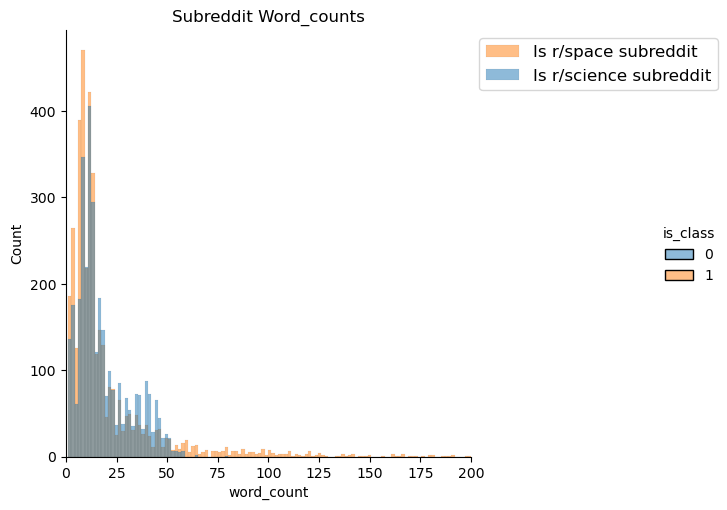

In [54]:
sns.displot(data = sci_pred.cleaned_data, 
            x = 'word_count', 
            hue = 'is_class');
plt.title('Subreddit Word_counts')
plt.gca().set_xlim(0, 200)
plt.legend(["Is r/space subreddit", "Is r/science subreddit"], fontsize=12, loc="upper left", bbox_to_anchor=(1,1))

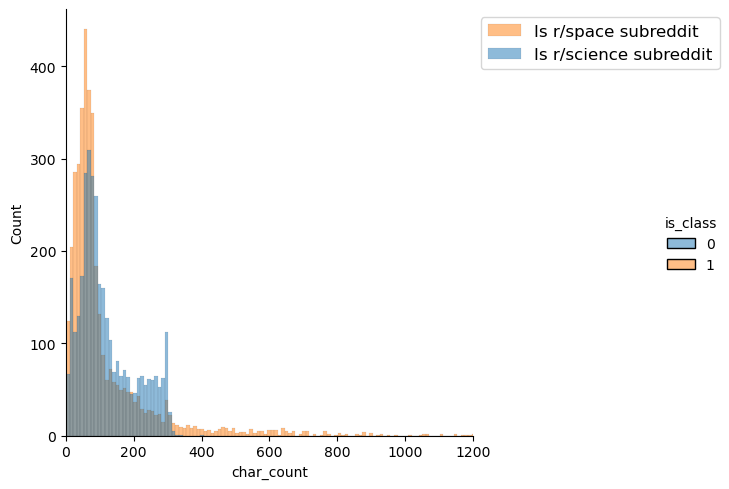

In [22]:
sns.displot(data = sci_pred.cleaned_data, 
            x = 'char_count', 
            hue = 'is_class');
plt.gca().set_xlim(0, 1200)
plt.legend(["Is r/space subreddit", "Is r/science subreddit"], fontsize=12, loc="upper left", bbox_to_anchor=(1,1))

In [23]:
sci_pred.cleaned_data

,is_class,content,word_count,char_count
0,1,the oldest known earth rock was found on the m...,18,96
1,1,not the best quality- meteor streaks between m...,15,86
2,1,"the moon, saturn and jupiter through my #NUM ""...",12,71
3,1,my boring life,3,14
4,1,my conjoined camera setup for infrared photogr...,16,114
...,...,...,...,...
7797,0,understanding international variations in kidn...,12,104
7798,0,study by the environmental working group (ewg)...,29,186
7799,0,covid vaccine hoarding might have cost more th...,11,64
7800,0,single synthetic ‘magic mushroom’ dose improve...,11,79


In [30]:
import re

def count_non_english_words(df, column):
    non_english_count = 0
    
    for index, row in df[column].iteritems():
        # Use a regular expression to search for non-English words
        match = re.search(r'[^\x00-\x7F]', row)
        if match:
            non_english_count += 1
            
    return non_english_count


In [36]:
space_count_nonenglish = count_non_english_words(sci_pred.cleaned_data[sci_pred.cleaned_data['is_class']==1],'content')/sci_pred.cleaned_data[sci_pred.cleaned_data['is_class']==1].shape[0]

In [37]:
sci_count_nonenglish = count_non_english_words(sci_pred.cleaned_data[sci_pred.cleaned_data['is_class']==0],'content')/sci_pred.cleaned_data[sci_pred.cleaned_data['is_class']==0].shape[0]

<BarContainer object of 2 artists>

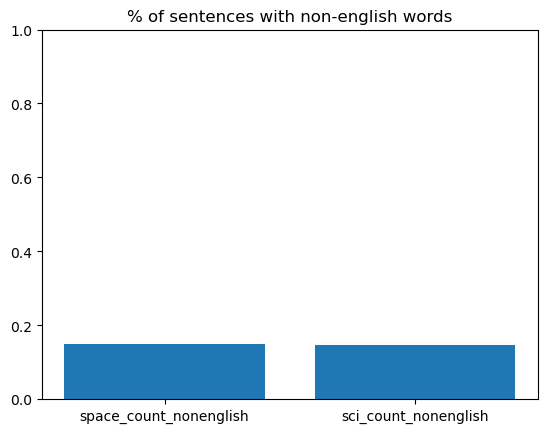

In [53]:
plt.ylim(0,1)
plt.title('% of sentences with non-english words')
plt.bar(['space_count_nonenglish', 'sci_count_nonenglish'] ,[space_count_nonenglish, sci_count_nonenglish] )